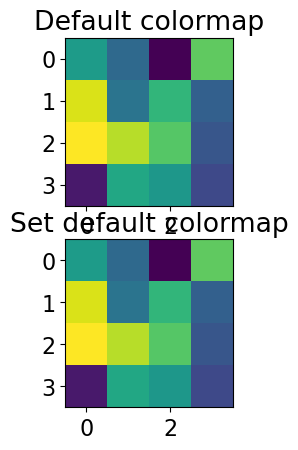

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath(".."), "code"))
import matplotlib.pyplot as plt
import seaborn as sns

from plotting_functions import *
from plotting_functions_unsup import *
from sklearn import cluster, datasets, metrics
from sklearn.datasets import make_blobs

import mglearn
#plt.style.use("seaborn")

plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (5, 4)

# Lecture 14: K-Means Clustering 

UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

### Announcements 

- HW6 will be posted this evening

### Lecture plan

- Clustering activity (~10 mins)
- Summary of the following pre-watch videos (~15 mins)
    - Clustering motivation ([video](https://youtu.be/caAuUAXwpb8))
    - K-Means clustering algorithm ([video](https://youtu.be/s6AvSZ1_l7I))
    - Choosing K ([video](https://youtu.be/M5ilrhcL0oY))
- iClicker questions (~10 mins)     
- Break (~5 mins)
- Introduction to GMMs (~15 mins)
- Demo: Clustering images (~15 mins)
- Final comments and summary (~5 mins)

## Clustering Activity (~5 mins)

Pick any of the two questions below and answer them in [this Google doc](https://docs.google.com/document/d/1aAhcA4EctqcewpYC_nV30PCwdkKLMrubQ_5QJEdLRK0/edit?usp=sharing).

> Note: The link in the lecture notes is the wrong one for this section. Use the one in the slides.

![](../img/food-clustering-activity.png)

- Categorize the food items in the image and write your categories. Do you think there is one correct way to cluster these images? Why or why not?
- Imagine that you have a personal cook who is an expert in making different varieties of hummus. What variety would you ask them to make?
- If you want to build a machine learning model to cluster such images how would you represent such images?
- What would be some applications of clustering these items?

### What is clustering? 

- Most of the data out there is unlabeled.  
- Getting labeled training data is often difficult, expensive, or simply impossible in some cases. 
- Can we extract some useful information from unlabeled data? 
- The most intuitive way is to group similar examples together to get some insight into the data even though we do not have the targets.  


**Clustering** is the task of partitioning the dataset into groups called clusters based on their similarities.

The goal of clustering is to discover underlying groups in a given dataset such that:
- examples in the same group are as similar as possible;
- examples in different groups are as different as possible.  

### Clustering: Input and (possible) output

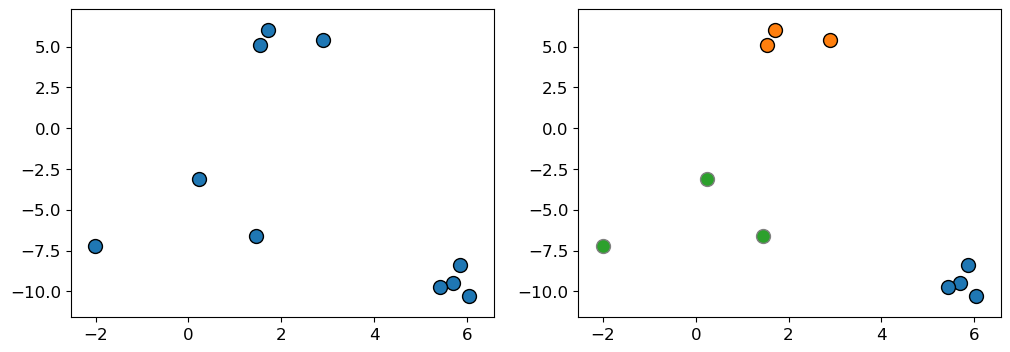

In [2]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
mglearn.discrete_scatter(X[:, 0], X[:, 1], ax = axes[0]);
mglearn.discrete_scatter(X[:, 0], X[:, 1], y=y, markers='o', ax = axes[1]);

- Usually the clusters are identified by a **cluster label**. 
- These labels are arbitrary, and relabeling the points (label switching) does not make a difference. 
- What we care about is which points have the same labels and which ones have different labels. 
- Very often we do not know how many clusters are there in the data or if there are any clusters at all. In real-world data, clusters are rarely as clear as in our toy example above. 
- There is a notion of coherent and semantically meaningful clusters in some sense but there is no absolute truth here. 

#### Example 1: What is "correct" grouping?
Which of the following grouping of emoticons is the "correct" grouping?

![](../img/emoticon_clustering_example.png)

- In clustering, meaningful groups are dependent on the **application**.
- It usually helps if we have some prior knowledge about the data and the problem.   
- This makes it hard for us to objectively measure the quality of a clustering algorithm (or think about "true" clusters).

### Common applications

#### Data exploration
Although there is no notion of the "right" answer, we might still get something useful out of clustering. There are a number of common applications for clustering. 

- Summarize or compress data. 
- Partition the data into groups before further processing. 
- For instance, you could use it in supervised learning setting as follows. Carry out clustering and examine performance of your model on individual clusters. If the performance is lower on a particular cluster, you could either try building a separate model for that cluster and improve the overall performance of your supervised model. 

#### Customer segmentation

- Understand landscape of the market in businesses and craft targeted business or marketing strategies tailored for each group.

![](../img/customer-segmentation.png)

[source](https://www.youtube.com/watch?v=zPJtDohab-g&t=134s)

#### Document clustering

Grouping articles on different topics from different news sources. For example, [Google News](https://news.google.com). 

![](../img/google_news.png)

**You'll be working on document clustering in the homework.**

### Other applications
- Social network analysis
- Medical imaging (image segmentation, image grouping, anomaly detection)
- Imputing missing data, data compression, privacy preservation 
- Biology discovering new cell types

## K-Means clustering [[video](https://youtu.be/s6AvSZ1_l7I)]

- Clustering is based on the notion of similarity or distances between points. 
- How do we determine similarity between points in a multi-dimensional space?
- Can we use something like $k$-neighbours for similarity? 
    - Yes! That's a good start!  
    - With $k$-neighbours we used Euclidean distances to find nearby points. 
    - We can use the same idea for clustering! 

K-Means is one of the most commonly used clustering algorithms. 

**Input**
- `X` $\rightarrow$ a set of data points  
- `K` (or $k$ or `n_clusters`) $\rightarrow$ number of clusters

**Output**
- `K` clusters (groups) of the data points 


### K-Means using `sklearn` 

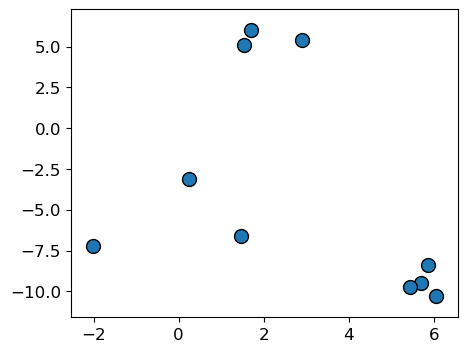

In [3]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
mglearn.discrete_scatter(X[:, 0], X[:, 1]);

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(X); # We are only passing X because this is unsupervised learning

In [5]:
clust_labels = kmeans.predict(X)
clust_labels

array([0, 1, 2, 1, 0, 0, 2, 2, 1, 0], dtype=int32)

In [6]:
kmeans.labels_

array([0, 1, 2, 1, 0, 0, 2, 2, 1, 0], dtype=int32)

In [7]:
cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[ 5.75745416, -9.48073598],
       [ 2.04861878,  5.51226051],
       [-0.10556679, -5.65013704]])

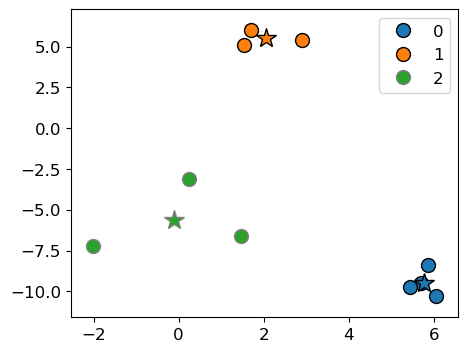

In [8]:
km_labels = kmeans.labels_
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o");
plt.legend();
mglearn.discrete_scatter(cluster_centers[:, 0], cluster_centers[:, 1], y =[0,1,2], s=15, markers='*');

In [9]:
new_examples = np.array([[-2, -2.5], [2, 4]])
kmeans.predict(new_examples).tolist()

[2, 1]

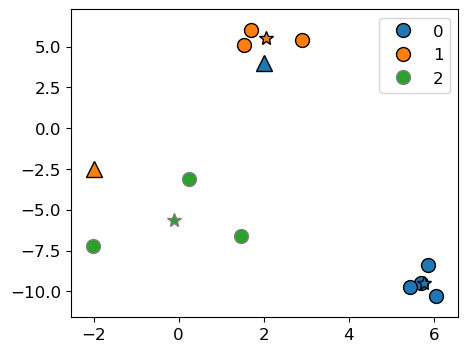

In [10]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
plt.legend()
mglearn.discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], y=[0,1,2], markers="*"
);
mglearn.discrete_scatter(new_examples[:, 0], new_examples[:, 1], y=kmeans.predict(new_examples).tolist(), markers="^",s=11);

### K-Means algorithm: Main idea 

- Represent each cluster by its cluster center and assign a cluster membership to each data point. 

**Chicken-and-egg problem!**

- If we knew cluster centers, we can simply assign each point to its nearest center.
- Similarly, if we knew assignments, we can calculate cluster centers.  
- But we do not know either 😟. 

A usual computer science answer to such problems is iterations!! 

### K-Means clustering algorithm

**Input**: Data points X and the number of clusters K

**Initialization**: K initial centers for the clusters

**Iterative process**:

repeat 
- Assign each example to the closest center.
- Estimate new centers as _average_ of observations in a cluster.

until **centers stop changing** or **maximum iterations have reached**.

### Initialization 

- Random initialization for K initial centers of the clusters. 

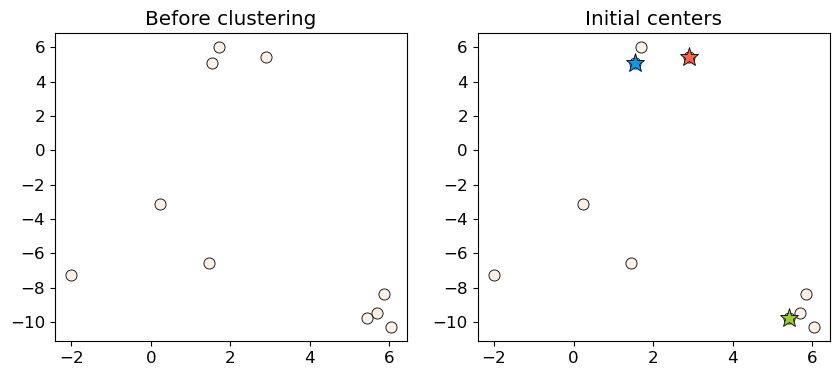

In [11]:
n_examples = X.shape[0]
k = 3

np.random.seed(seed=3)
centers_idx = np.random.choice(range(0, n_examples), size=k)
centers = X[centers_idx]
plot_km_initialization(X, centers)

### Iterative process

#### How to find closest centers? 

- First step in the iterative process is assigning examples to the closest center. 
- Let's consider distance of an example to all centers and assign that example to the closest center.  

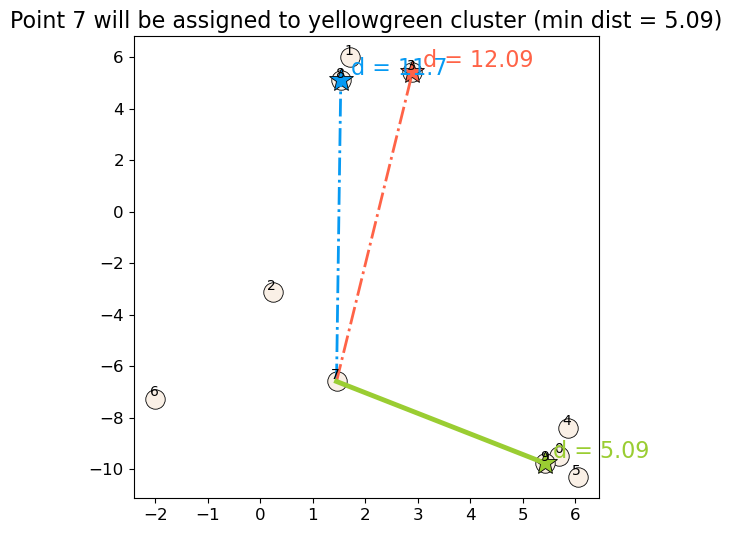

In [12]:
fig = plt.figure(figsize=(6, 6))
plot_example_dist(X, centers, fig, point_ind=7)

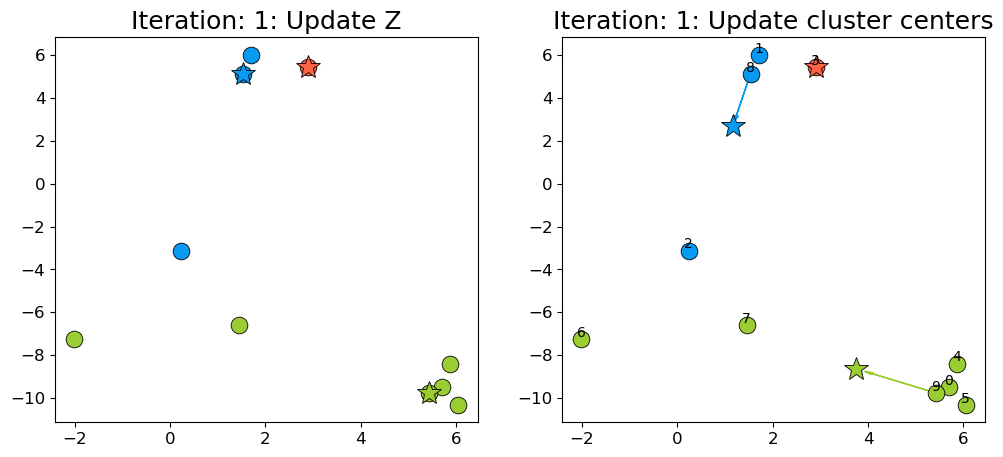

In [13]:
dist, Z = update_Z(X, centers) 
new_centers = update_centers(X, Z, centers, k)

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
plot_km_iteration(X, Z, centers, new_centers, 1, fig, ax)

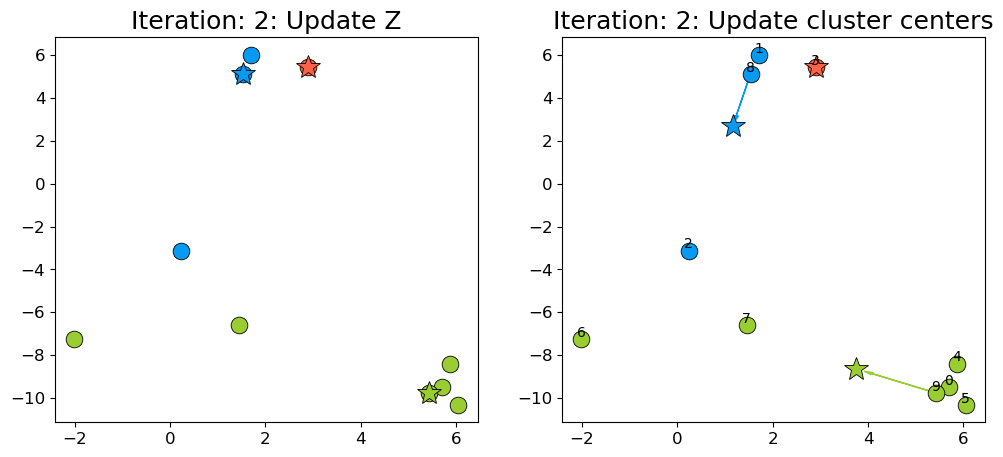

In [14]:
dist, Z = update_Z(X, centers) 
new_centers = update_centers(X, Z, centers, k)

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
plot_km_iteration(X, Z, centers, new_centers, 2, fig, ax)

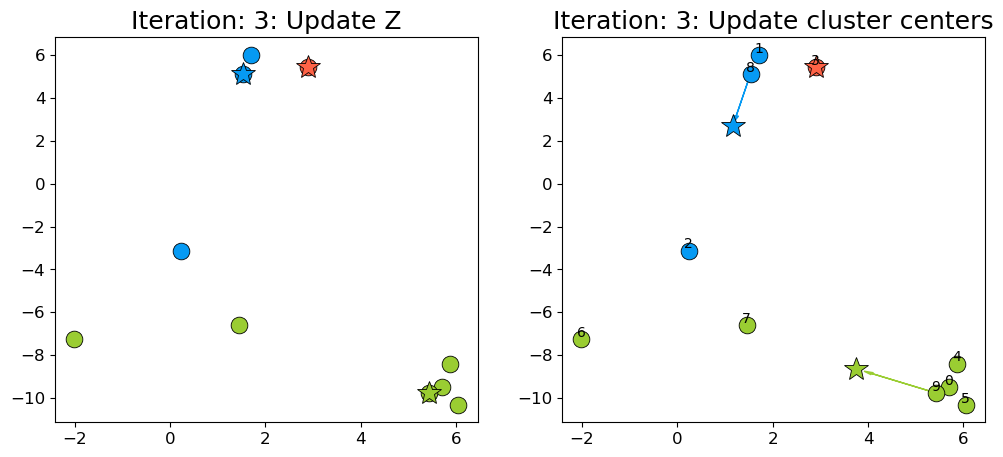

In [15]:
dist, Z = update_Z(X, centers) 
new_centers = update_centers(X, Z, centers, k)

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
plot_km_iteration(X, Z, centers, new_centers, 3, fig, ax)

### When to stop?

- Seems like after iteration 4 our centroids aren't changing anymore. 
- The algorithm has converged. So we stop! 
- K-Means always converges. It doesn't mean it finds the "right" clusters. It can converge to a sub-optimal solution.   

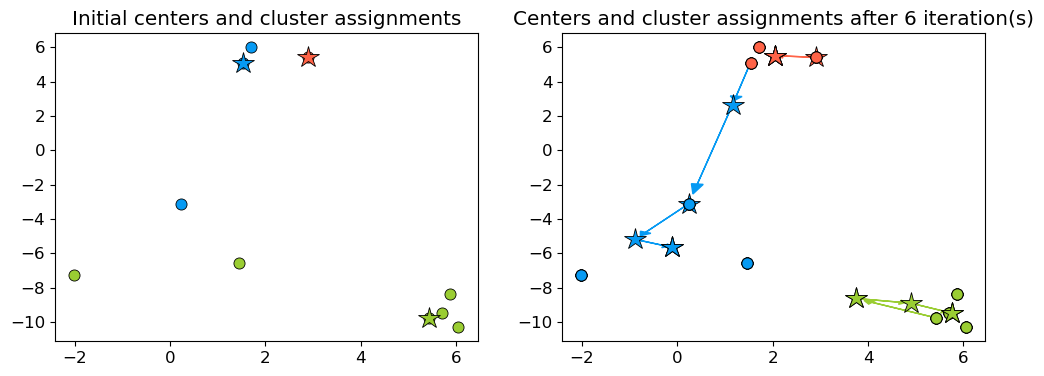

In [16]:
plot_km_iterative(X, X[centers_idx], 6)

### A comment on initialization

- The initialization of K-Means is stochastic, can this affect the results?
    - Yes! Big time.  
- Let's look at an example.

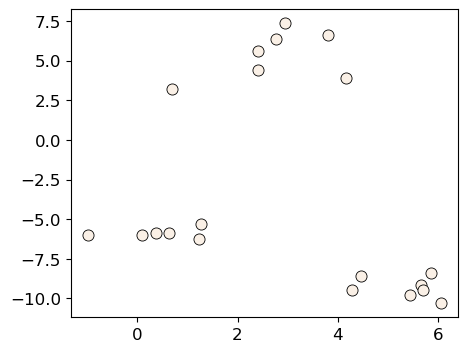

In [17]:
X_init, y_init = make_blobs(n_samples=20, centers=3, n_features=2, random_state=10)
discrete_scatter(X_init[:, 0], X_init[:, 1], markers="o");

In [18]:
k = 3
n_examples = X_init.shape[0]

### Example: Bad initialization 

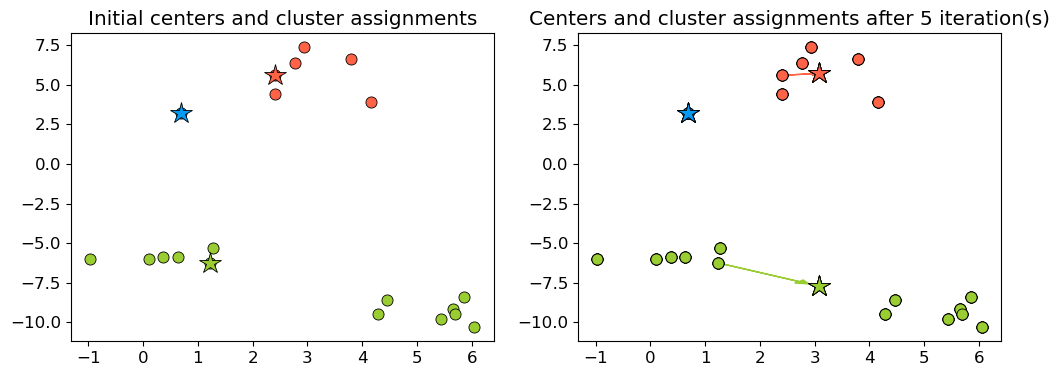

In [23]:
np.random.seed(seed=10)
centroids_idx_init = np.random.choice(range(0, n_examples), size=k)
plot_km_iterative(X_init, X_init[centroids_idx_init], 5)

### Example: Better initialization 
The following initialization seems much better. 

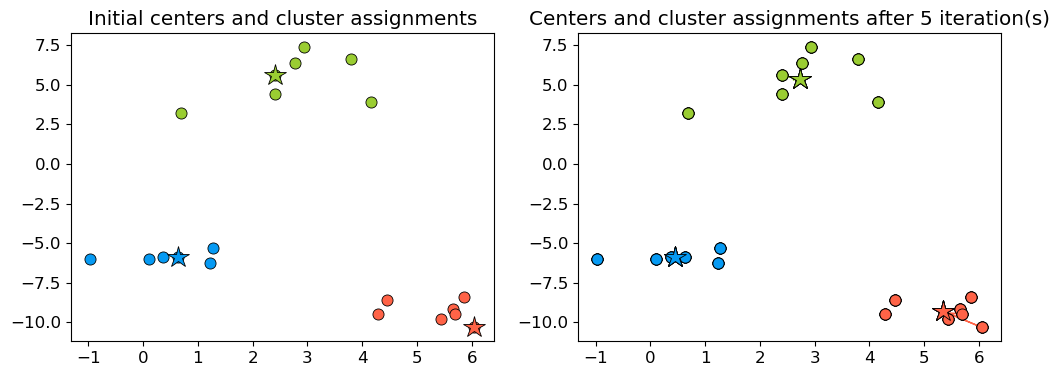

In [24]:
np.random.seed(seed=2)
centroids_idx = np.random.choice(range(0, n_examples), size=k)
plot_km_iterative(X_init, X_init[centroids_idx], 5)

### What can we do about it?

- One strategy is to run the algorithm several times. 
    - Check out `n_init` parameter of [`sklearn`'s `KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 
- Is it possible to pick `K` in a smart way? 
    - Yes! We can use the so-called [K-Means++](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf).
    - Intuitively, it picks the initial centroids which are far away from each other. 
    - In other words, K-Means++ gives more chance to select points that are far away from centroids already picked.    
    - By default `sklearn` uses this strategy for initialization. 

### 14.1 Select all of the following statements which are **True** (iClicker)
**iClicker cloud join link: https://join.iclicker.com/SNBF**

- (A) K-Means algorithm always converges to the same solution.
- (B) $K$ in K-Means should always be $\leq$ # of features.
- (C) In K-Means, it makes sense to have $K$ $\leq$ # of examples. 
- (D) In K-Means, in some iterations some points may be left unassigned. 

### 14.2 Select all of the following statements which are **True** (iClicker)
**iClicker cloud join link: https://join.iclicker.com/SNBF**

- (A) K-Means is sensitive to initialization and the solution may change depending upon the initialization. 
- (B) K-means terminates when the number of clusters does not increase between iterations.
- (C) K-means terminates when the centroid locations do not change between iterations.
- (D) K-Means is guaranteed to find the optimal solution. 

### Choosing K [[video](https://youtu.be/M5ilrhcL0oY)]

In the previous activity you were asked about hummus of your taste. Suppose you don't have a cook anymore and you are to pick one of the following options, which one would you pick? 
- (A) Original hummus
- (B) Roasted garlic hummus
- (C) Lemon hummus

![](../img/hummus.png)

### Hyperparameter tuning for the number of clusters

- When running K-Means we need to decide the number of clusters in advance (`n_clusters` in `sklearn`). How do we pick this hyperparameter?
- In supervised setting we carried out hyperparameter optimization based on cross-validation scores. 
- Since in unsupervised learning we do not have the target values, it becomes difficult to objectively measure the effectiveness of the algorithms.
- There is no definitive or satisfactory approach.
- However, some strategies might be useful to help you determine K. 

### Method 1: The Elbow method

- This method looks at the sum of **intra-cluster distances**, which is also referred to as **inertia**. 
- The intra-cluster distance in our toy example above is given as   

$$\sum_{P_i \in C_1}  distance(P_i, C_1)^2 + \sum_{P_i \in C_2}  distance(P_i, C_2)^2 + \sum_{P_i \in C_3} distance(P_i, C_3)^2$$

Where 
- $C_1, C_2, C_3$ are centroids 
- $P_i$s are points within that cluster
- $distance$ is the usual Euclidean distance. 

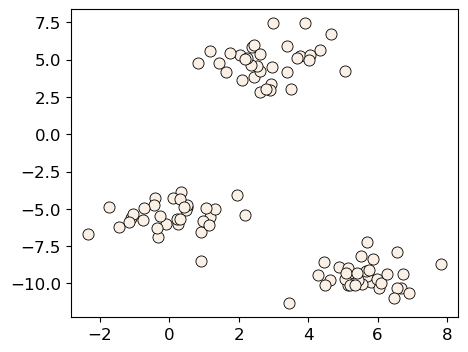

In [25]:
XX, y = make_blobs(centers=3, n_features=2, random_state=10)
discrete_scatter(XX[:, 0], XX[:, 1], markers="o");

In [27]:
d = {"K": [], "inertia": []}
for k in range(1, 100, 10):
    model = KMeans(n_clusters=k, n_init='auto').fit(XX)
    d["K"].append(k)
    d["inertia"].append(model.inertia_)
pd.DataFrame(d)    

,K,inertia
0,1,4372.460950
1,11,62.521220
2,21,28.296204
3,31,14.787738
4,41,7.119160
5,51,3.978918
6,61,1.985659
7,71,1.023802
8,81,0.363641
9,91,0.057535


- The inertia decreases as K increases. 
- Question: Do we want inertia to be small or large? 
- The problem is that we can't just look for a $k$ that minimizes inertia because it decreases as $k$ increases.
    - If I have number of clusters = number of examples, each example will have its own cluster and the intra-cluster distance will be 0.  
- Instead we evaluate the trade-off: "small k" vs "small intra-cluster distances". 

In [28]:
def plot_elbow(w, h, inertia_values):
    plt.figure(figsize=(w, h))
    plt.axvline(x=3, linestyle="-.", c="black")
    plt.plot(range(1, 10), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h))
    ax.set_xlabel("K", fontsize=w+h)
    ax.set_ylabel("Inertia", fontsize=w+h)

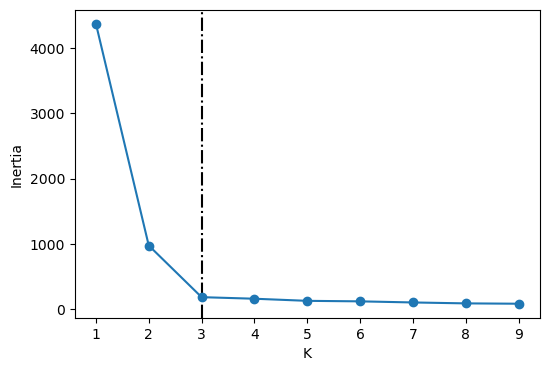

In [29]:
inertia_values = list()
for k in range(1, 10):
    inertia_values.append(KMeans(n_clusters=k, n_init='auto').fit(XX).inertia_)
plot_elbow(6, 4, inertia_values)

- From the above plot, we could argue that three clusters (the point of inflection on the curve) are enough.
- The inertia decreases when clusters are greater than 3. However it's not a big improvement and so we prefer K=3. 
- In this toy example, it's the plot is kind of clear and easy to interpret but it can be hard to interpret in real life examples. 

There is a package called [`yellowbrick`](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) which can be used to create these plots conveniently. 

You can install it as follows: 

`conda install -c districtdatalabs yellowbrick`

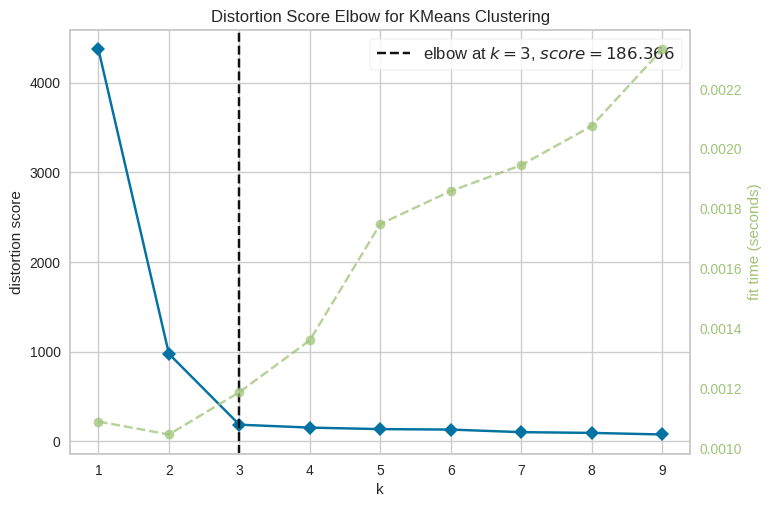

In [30]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.show();

### Method 2: The Silhouette method

- Not dependent on the notion of cluster centers. 
- Calculated using the **mean intra-cluster distance** ($a$) and the **mean nearest-cluster distance** ($b$) for each sample.

### Mean intra-cluster distance ($a$)

- Suppose the green point below is our sample. 
- Average of the distances of the green point to the other points in the same cluster.
  - These distances are represented by the black lines. 

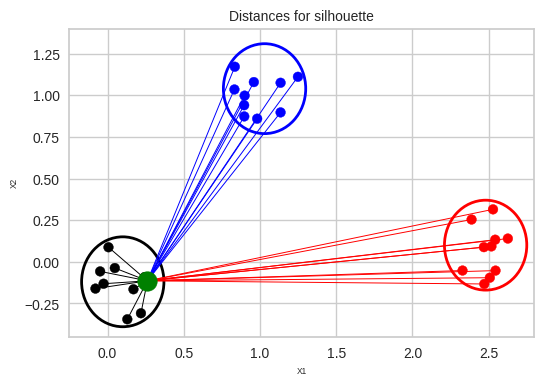

In [31]:
plot_silhouette_dist(6, 4)

### Mean nearest-cluster distance ($b$)

- Average of the distances of the green point to the blue points is smaller than the average of the distances of the green point to the red points. So the **nearest cluster** is the blue cluster. 
- So the mean nearest-cluster distance is the average of the distances of the green point to the blue points.  

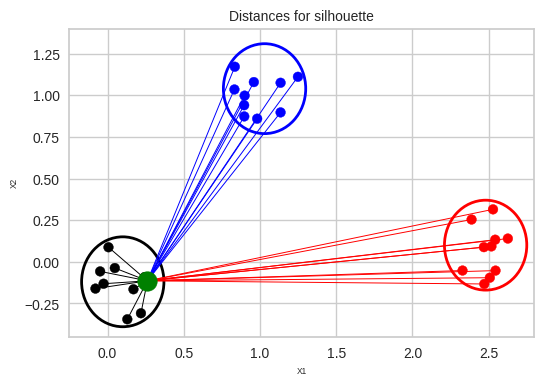

In [33]:
plot_silhouette_dist(6, 4)

### Silhouette distance for a sample 

- the difference between the **the average nearest-cluster distance** ($b$) and **average intra-cluster distance** ($a$) for each sample, normalized by the maximum value

$$\frac{b-a}{max(a,b)}$$

- The best value is 1. 
- The worst value is -1 (samples have been assigned to wrong clusters).
- Value near 0 means overlapping clusters. 

The overall **Silhouette score** is the average of the Silhouette scores for all samples. We can visualize the silhouette score for each example individually in a silhouette plot (hence the name), see below.

### Using Silhouette scores to select the number of clusters

- The following plots show the Silhouette scores for each sample in that cluster. 
- Higher values indicate well-separated clusters. 
- The size of the Silhouette shows the number of samples and hence shows imbalance of data points in clusters.  

In [34]:
from yellowbrick.cluster import SilhouetteVisualizer

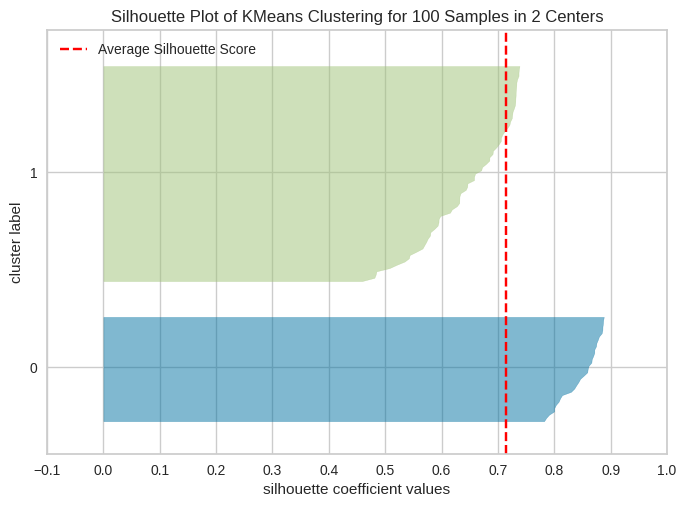

In [35]:
model = KMeans(2, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.show(); # Finalize and render the figure

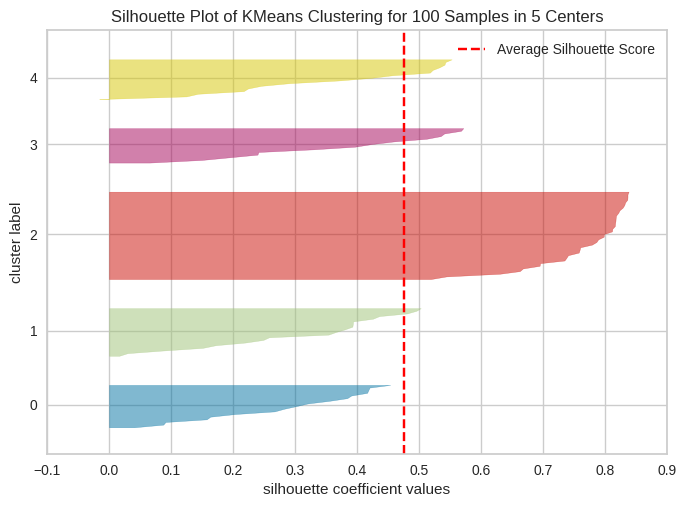

In [36]:
model = KMeans(5, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(XX)
visualizer.show();

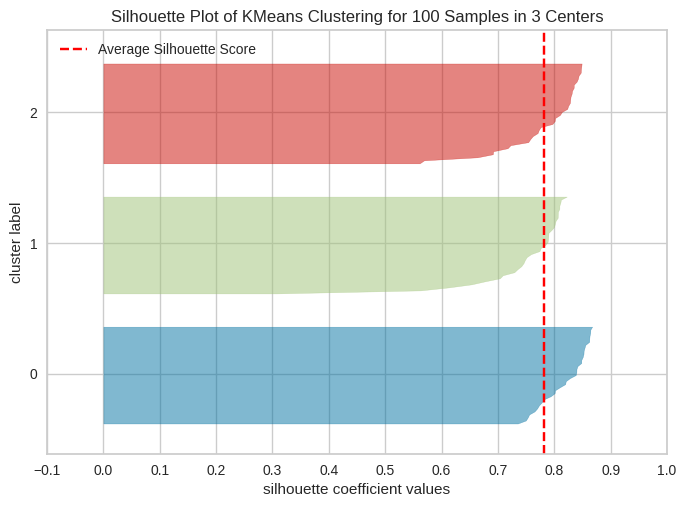

In [37]:
model = KMeans(3, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(XX)
visualizer.show();

### What to look for in these plots?

- Unlike inertia, larger values are better because they indicate that the point is further away from neighbouring clusters.
- The thickness of each silhouette indicates the cluster size.
- The shape of each silhouette indicates the "goodness" for points in each cluster.
- The length (or area) of each silhouette indicates the goodness of each cluster.
- A slower dropoff (more rectangular) indicates more points are "happy" in their cluster.
- We can apply Silhouette method to clustering methods other than K-Means. 

### 14.3 Select all of the following statements which are **True** (iClicker)
**iClicker cloud join link: https://join.iclicker.com/SNBF**

- (A) If you train K-Means with `n_clusters`= the number of examples, the inertia value will be 0. 
- (B) The elbow plot shows the tradeoff between within cluster distance and the number of clusters.
- (C) Unlike the Elbow method, the Silhouette method is not dependent on the notion of cluster centers.
- (D) The elbow plot is not a reliable method to obtain the optimal number of clusters in all cases. 
- (E) The Silhouette scores ranges between -1 and 1 where higher scores indicates better cluster assignments.

### Introduction to Gaussian mixture models (high-level)

- K-Means is great but it cannot handle oddly shaped clusters. 
- In K-Means our clusters are solely defined by cluster centers.
- Let's look at a toy example.

In [39]:
from scipy.stats import multivariate_normal, norm
from sklearn.datasets import make_blobs, make_circles, make_moons

dataset_sub1 = multivariate_normal.rvs(
    mean=[2, 4], cov=[[12, 11.5], [11.5, 12]], size=200, random_state=42
)

dataset_sub2 = multivariate_normal.rvs(
    mean=[11, -3], cov=[[12, -10], [-10, 12]], size=100, random_state=42
)

dataset_sub3,y = make_blobs(random_state=42, centers =1, cluster_std=1.8, n_samples=50)
dataset_sub4 = dataset_sub3 + np.array([4, -14])

X_train = np.vstack([dataset_sub1, dataset_sub2, dataset_sub4])

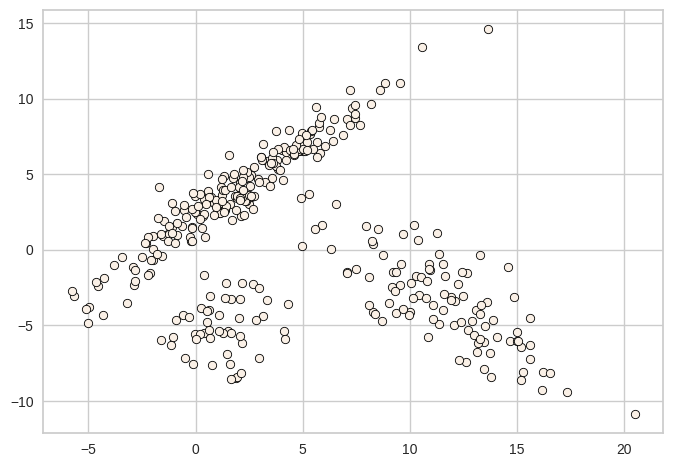

In [40]:
discrete_scatter(X_train[:,0], X_train[:,1],s=6);mb

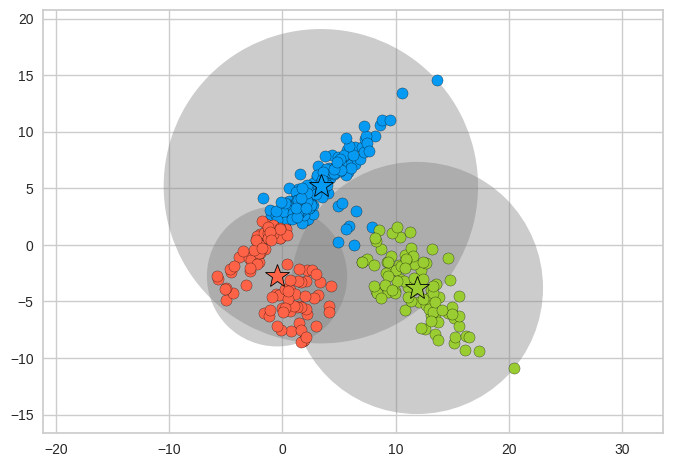

In [45]:
km = KMeans(n_clusters=3, n_init="auto")
km.fit(X_train)
km_labels = km.labels_
plot_kmeans_circles(km, X_train, n_clusters=3)

- K-Means is not doing a good job. 
- One limitation of K-Means is that it only takes into account means of data points and not the spread of the data points. 
- How about taking into account the covariance matrices, i.e., how spread out the data is?
- Is it possible to generalize K-Means clustering to incorporate information about the covariance structure of the data as well as the centers? 
- One idea is to model the data as a weighted sum of Gaussian distributions, where each Gausssian, referred to as a **component** of the mixture, has its own mean vector and covariance matrix and a corresponding weight. These models are referred to as **mixture of Gaussians** or **Gaussian mixture models**. 
- There is a lot to say about these models. In the interest of time, we'll keep things high level in this course. 
- First, let's try it out with sklearn. 

In [43]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type="full") # more on covariance_type in a bit 
gmm.fit(X_train)
gmm_labels = gmm.predict(X_train)

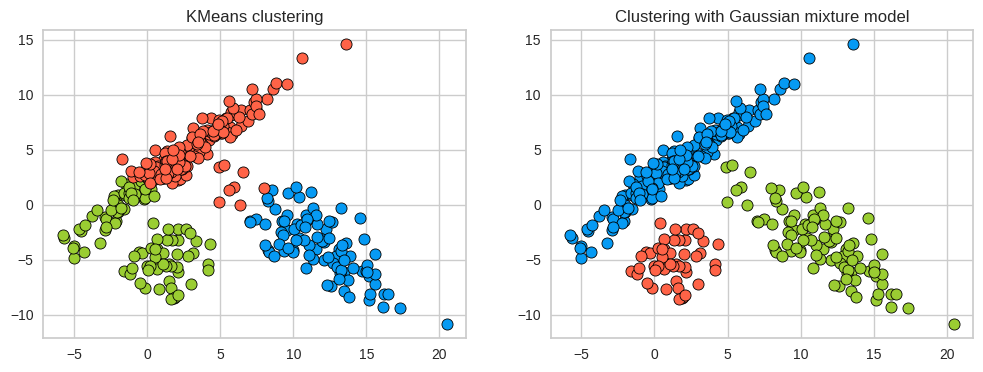

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4)) 
discrete_scatter(X_train[:, 0], X_train[:, 1], km_labels, c=gmm_labels, markers="o", ax=ax[0]);
ax[0].set_title('KMeans clustering')
discrete_scatter(X_train[:, 0], X_train[:, 1], gmm_labels, c=gmm_labels, markers="o", ax=ax[1]);
ax[1].set_title('Clustering with Gaussian mixture model');

In [47]:
gmm.means_

array([[ 1.93609356,  3.96311554],
       [11.38137298, -3.31731115],
       [ 1.25596947, -5.15011412]])

In [48]:
gmm.covariances_

array([[[10.95673803, 10.63462235],
        [10.63462235, 11.26072047]],

       [[ 9.09449493, -7.25892116],
        [-7.25892116,  9.394036  ]],

       [[ 1.97803583,  0.26628563],
        [ 0.26628563,  3.11174164]]])

In [49]:
gmm.weights_

array([0.57275449, 0.28682168, 0.14042383])

In [50]:
np.sum(gmm.weights_)

0.9999999999999998

#### How does it work? (high-level)

- Given $k$, the number of clusters or the number of components, we want to fit Gaussian blobs to the data. Each Gaussian will have it's own mean vector and covariance matrix. 
- This is a **generative model**; it models the probability of a given data point being generated from the mixture of the Gaussians.  

$$P(x) = \sum_{j=1}^{k} \pi_k \mathcal{N}(x, \mu_k, \Sigma_k)$$

- $x \rightarrow$ a data point
- $\pi_k \rightarrow$ the weight of component $k$ (between 0 to 1)
- $k \rightarrow$ the number of clusters or the number of components
- $\mu_k \rightarrow$ the mean vector of component $k$
- $\Sigma_k \rightarrow$ the covariance matrix associated with component $k$

The generative story of the model assumes that each data point in the dataset is generated from one of the Gaussian components. So for each example $x$: 
- Choose component $k$ with probabilities proportional to the weight $\pi_k$ (prior probability) of the components. 
- Choose example $x$ from the Gaussian distribution associated with the $k^{th}$ component: $\mathcal{N}(x, \mu_k, \Sigma_k)$ 

 A mixture of Gaussians can model much more complicated shapes than a single Gaussian distribution. 

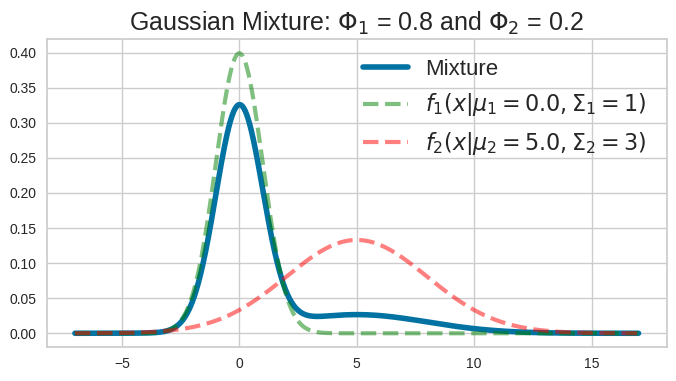

In [56]:
fig = plt.figure(figsize=(8, 4))        
Gaussian_mixture_1d(ϕ1=0.8, ϕ2=0.2, fig=fig)

The goal is to estimate $\pi_k$, $\mu_k$, $\Sigma_k$ for all clusters or components $k$. 
- It's a non-convex optimization problem 
- It is sensitive to initialization. Usually, it's initialized with K-Means. 
- Generally used with "soft" assignments. Each point contributes to the mean and covariance of each component but the points that are far away only contribute a little.  

Under the hood it finds these parameters using an algorithm called **Expectation Maximization**. The idea is to treat the clusters as **hidden variables**. 

- Choose starting guesses for the location and shape
- Repeat until converged:
    - E-step: for each point, find weights encoding the probability of membership in each cluster
    - M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights
    

- spherical: each component has its own single variance
- diag: each component has its own diagonal covariance matrix which results in axis-aligned clusters 
- tied: all components share the same general covariance matrix which results in Gaussian components with the same shape and orientations  
- full: each component has its own general covariance matrix which results in Gaussian components with different shapes and different orientations 

In [59]:
k=3
estimators = {
    cov_type: GaussianMixture(
        n_components=k, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

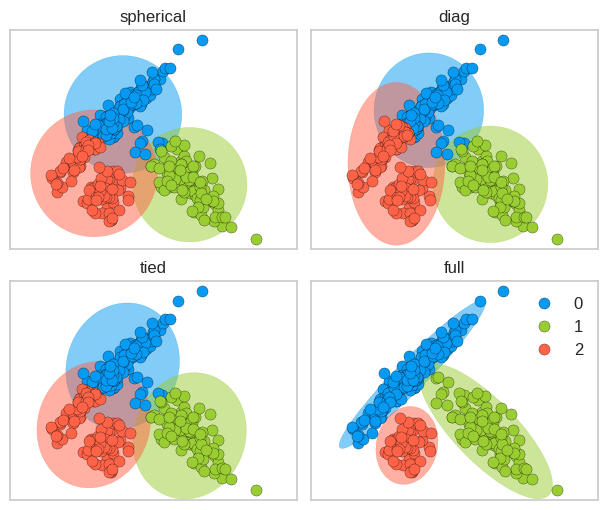

In [60]:
plot_gmm_cov_types(estimators, X_train)

In [61]:
pd.DataFrame(estimators['full'].predict_proba(X_train)[10:20]).round(4)

,0,1,2
0,0.9996,0.0000,0.0004
1,0.9899,0.0101,0.0000
2,0.9966,0.0034,0.0000
3,0.9999,0.0001,0.0000
4,0.9961,0.0039,0.0000
5,0.9935,0.0065,0.0000
6,0.9927,0.0073,0.0000
7,0.9981,0.0000,0.0019
8,0.9839,0.0157,0.0003
9,1.0000,0.0000,0.0000


Since GMM is a generative model, we can get the log likelihood of the model generating this data. 

In [62]:
estimators['full'].score(X_train)

-5.073780282241252

It's possible to do model selection, i.e., selecting the appropriate covariance type and the number of components based on Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC) which penalize complex models. 

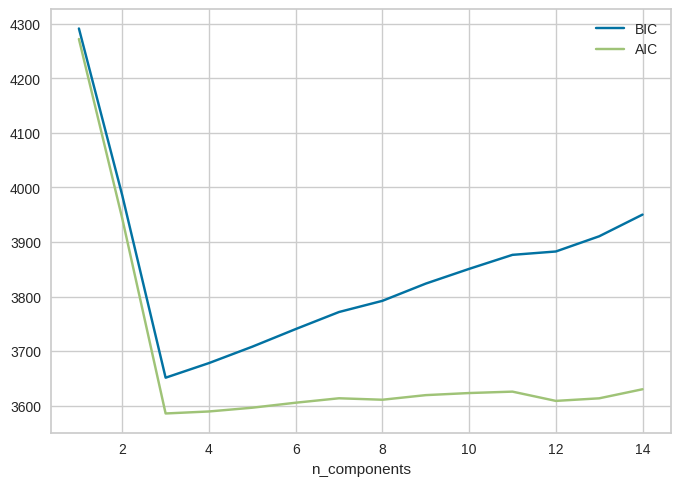

In [63]:
n_components = range(1,15)

gmm_models = [GaussianMixture(n_components=k).fit(X_train) for k in n_components]
aic_scores = [model.aic(X_train) for model in gmm_models]
bic_scores = [model.bic(X_train) for model in gmm_models]

data = np.vstack([n_components, aic_scores, bic_scores]).T
pd.DataFrame(data, columns=['n_components', 'aic', 'bic'])
np.argmin(bic_scores)
plt.plot(n_components, bic_scores, label='BIC')
plt.plot(n_components, aic_scores, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

### 14.4 Select all of the following statements which are **True** (iClicker)
**iClicker cloud join link: https://join.iclicker.com/SNBF**

- (A) GMMs are more flexible than KMeans but can be computationally expensive. 
- (B) In GMMs, each data point has a probability associated with each component. 
- (C) GMMs are sensitive to the initialization. 
- (D) The number of components in a GMM has no effect on the model's ability to fit the data. 

### Final comments, summary, and reflection

### Important points to remember

- Clustering is a common unsupervised approach to identify underlying structure in data and grouping points based on similarity. 
- Appropriate data representation is crucial for meaningful clustering. 
- We did not talk much about distance metrics but that is another importance consideration in clustering.
- K-Means is a popular clustering algorithm. 

**Clustering with K-Means**
- It requires us to specify the number of clusters in advance. 
- Each example is assigned to one (and only one) cluster.
- The labels provided by the algorithm have no actual meaning. 
- The centroids live in the same space as of the dataset but they are **not** actual data points, but instead are average points.
- It always converges. Convergence is dependent upon the initial centers and it may converge to a sub-optimal solution. 
- Two popular ways to provide insight into how many clusters are reasonable for the give problem are: **the Elbow method** and **the Silhouette method**.  

**Clustering with Gaussian mixture models**

- Gaussian mixture models model the distribution of data as a mixture of $k$ Gaussian components. 
- Each Gaussian has a different mean vector and co-variance matrix and a weight associated with it, which control its location, shape, and complexity. 
- You can control and shape and complexity of the Gaussians by restricting the covariance matrix. There are four common ways to do this in `sklearn`: spherical, diag, tied, full 
- Gaussian mixture models are a probabilistic model; they assign a probability to each data point belonging to each cluster. In `sklearn`, we can access these soft assignments using `predict_proba` scores. 
- The model also gives us the log likelihood of fitting the data. It's possible to calculate AIC and BIC scores and pick the number of components where these scores are the lowest. 